# A/B тест эффективности чата с менеджером
**Контекст проекта:**\
Команда внедрила новое решение на сайте — чат с менеджером. Менеджеры продукта говорят о том, что чат назойливый и это вызовет негативный опыт у пользователей, а менеджеры по продажам считают, что так получится больше продавать. Пришли результаты A/B теста — одной выборке показывали чат, а другой нет. Оцените результаты теста и опишите выводы. 

**Описание данных:**\
лог с результатами AAB теста: **ab_log.csv**\
**Поля:**\
event - событие\
user_id - id пользователя\
EventTime - время события\
Group - группа события\

**Экспериментальные группы, Group:**\
A1 - контрольная группа\
A2 - контрольная группа\
B - экспериментальная группа

<a id="content"></a>
## Содержание
[Шаг 1. Загрузка данных и общая оценка датасета](#1)

[Шаг 2. Подготовка данных](#2)
- [2.1. Обработка дубликатов](#21)
- [2.2. Проверка целостности данных](#22)
- [2.3. Создание дополнительных полей](#23)

[Шаг 3. Изучение и проверка данных](#3) 

[Шаг 4. Обработка результатов AAB теста](#4)
- [4.1. Подготовка данных ](#41)
- [4.2. Проверка результатов теста ](#42)

**[Общий вывод](#summary)**

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# настройка окружения
pd.options.display.max_columns=None
pd.options.display.float_format='{:.2f}'.format
sns.set(style='whitegrid')
plt.style.use('seaborn-pastel')


<a id="1"></a>
## 1. Загрузка данных и общая оценка датасета [▲](#content)

In [3]:
df_test = pd.read_csv('ab_log.csv')
df_test.head()

,event,user_id,EventTime,Group
0,StartReadingOffer,7241586465170049200,1564978321,A2
1,OpenProductCard,4998498972125515821,1564678223,A2
2,StartReadingOffer,5794343176311717876,1564681595,B
3,StartReadingOffer,3371640160394640961,1564635919,A1
4,OpenProductCard,4623191541226589455,1564695060,A1


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154788 entries, 0 to 154787
Data columns (total 4 columns):
event        154788 non-null object
user_id      154788 non-null int64
EventTime    154788 non-null int64
Group        154788 non-null object
dtypes: int64(2), object(2)
memory usage: 4.7+ MB


In [5]:
df_test.describe(include=[np.object])

,event,Group
count,154788,154788
unique,4,3
top,StartReadingOffer,B
freq,74108,55143


<a id="2"></a>
## 2. Подготовка данных [▲](#content)

In [6]:
# изменение имен столбцов (для удобства)
df_test = df_test.rename(columns={'EventTime':'event_time',
                                  'Group':'group'})

In [7]:
# преобразование даты-времени из unix формата в datetime
df_test['event_time'] = pd.to_datetime(df_test['event_time'], unit='s')
df_test.head()

,event,user_id,event_time,group
0,StartReadingOffer,7241586465170049200,2019-08-05 04:12:01,A2
1,OpenProductCard,4998498972125515821,2019-08-01 16:50:23,A2
2,StartReadingOffer,5794343176311717876,2019-08-01 17:46:35,B
3,StartReadingOffer,3371640160394640961,2019-08-01 05:05:19,A1
4,OpenProductCard,4623191541226589455,2019-08-01 21:31:00,A1


<a id="21"></a>
#### 2.1. Обработка дубликатов [**↑**](#2)

In [8]:
# проверка на дубликаты
print('Число полных дубликатов в таблице:', df_test.duplicated().sum())

Число полных дубликатов в таблице: 296


In [9]:
# визуальная проверка записей дубликатов
df_test[df_test.duplicated(keep=False)==True].sort_values(by='event_time').head(4)

,event,user_id,event_time,group
104580,StartReadingOffer,5613408041336554427,2019-07-30 08:36:24,B
9569,StartReadingOffer,5613408041336554427,2019-07-30 08:36:24,B
10426,OpenProductCard,1694940645348351119,2019-07-31 22:08:19,B
44151,OpenProductCard,1694940645348351119,2019-07-31 22:08:19,B


**Некоторые записи полностью дублируются - их удаляем:**

In [10]:
# удаление дубликатов 
df_test.drop_duplicates(inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154492 entries, 0 to 154787
Data columns (total 4 columns):
event         154492 non-null object
user_id       154492 non-null int64
event_time    154492 non-null datetime64[ns]
group         154492 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 5.9+ MB


<a id="22"></a>
#### 2.2. Проверка целостности данных [**↑**](#2)

In [11]:
# оценка целостности данных в столбце 'event'
df_test['event'].value_counts()

StartReadingOffer    74044
StartCheckProduct    30114
OpenProductCard      27699
OpenPaymentScreen    22635
Name: event, dtype: int64

**Имеем 4 варианта событий, опечаток в названиях нет. Все корректно.**

In [12]:
# оценка целостности данных в столбце 'group'
df_test['group'].value_counts()

B     55018
A2    49828
A1    49646
Name: group, dtype: int64

**Обозначения групп соответствуют заявленным, "лишние" отсутствуют. Число записей в выборках имеет расхождение в пределах 10%. Все в порядке.**

In [13]:
# проверка корректности временных меток (оценка разброса мин-макс)
df_test['event_time'].describe()

count                  154492
unique                 112980
top       2019-08-01 14:57:15
freq                        9
first     2019-07-25 05:00:16
last      2019-08-05 11:47:10
Name: event_time, dtype: object

**Диапазон дат с 25 июля по 05 августа 2019 года. "Выбросы" возможных ошибок отсутствуют.**

<a id="23"></a>
#### 2.3. Создание дополнительных полей [**↑**](#2)

In [14]:
# создаем отдельные столбцы с датой 'date' и со временем 'time'
df_test['date'] = df_test['event_time'].dt.date
df_test['time'] = df_test['event_time'].dt.time
df_test.head()

,event,user_id,event_time,group,date,time
0,StartReadingOffer,7241586465170049200,2019-08-05 04:12:01,A2,2019-08-05,04:12:01
1,OpenProductCard,4998498972125515821,2019-08-01 16:50:23,A2,2019-08-01,16:50:23
2,StartReadingOffer,5794343176311717876,2019-08-01 17:46:35,B,2019-08-01,17:46:35
3,StartReadingOffer,3371640160394640961,2019-08-01 05:05:19,A1,2019-08-01,05:05:19
4,OpenProductCard,4623191541226589455,2019-08-01 21:31:00,A1,2019-08-01,21:31:00


In [15]:
# добавляем столбец с ID операции (используем текущий индекс датасета)
df_test['operation_id'] = df_test.index

**Вывод:** Выполнено преобразование формата даты-времени, выполнена проверка заполнения полей 'event', 'group'. Удалены дубликаты. Добавлены столбцы с датой и временем события. Диапазон дат у данных с 25 июля по 05 августа 2019 года

<a id="3"></a>
## Шаг 3. Изучение и проверка данных [▲](#content)

После удаления дубликатов в логе осталось **154 492 записей.** 

#### Оценка временного диапазона имеющихся данных

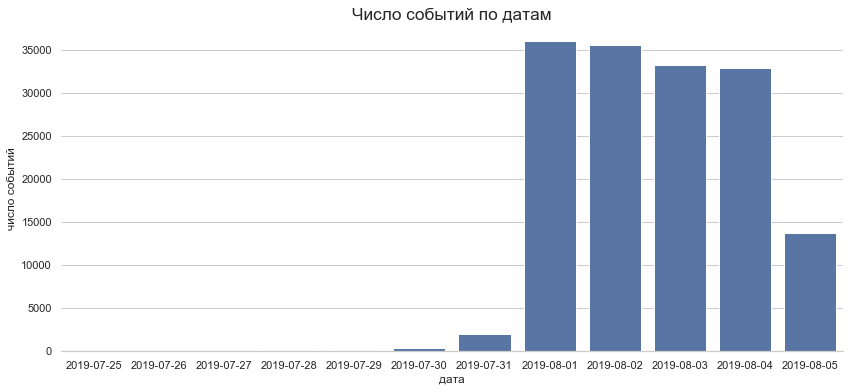

In [16]:
# строим гистограмму зарегистрированных событий по датам

f, ax = plt.subplots(figsize=(14, 6))
#sns.set_color_codes("muted")
sns.barplot(data=df_test.groupby('date')['event'].count().reset_index(),
            x="date", y="event", color='b');
# Добавляем заголовок легенду и подписи осей
ax.set_title('Число событий по датам', fontdict={'fontsize': 'x-large'})
ax.set(ylabel="число событий", xlabel="дата")
sns.despine(left=True);

На графике видно, что основной массив событий происходил начиная с **01 августа по 05 августа 2019 года.** Возможно влияют особенности алгоритма регистрации данных эксперимента. Тем не менее, если соблюдено разделение на группы, данные могут быть вполне корректны. Проверим число возможных потреь при "обрезке":

In [17]:
# Число записей после 01 августа 2019г.:
records_after_190731 = df_test[df_test['date'] > np.datetime64('2019-07-31')].shape[0]

print('Общее число записей:', df_test.shape[0])
print('Число записей после 01 августа 2019г.:', records_after_190731)
print('Потери данных при обрезке записей до 01 августа 2019г.: {:.2%}'.format(1 - records_after_190731 / df_test.shape[0]))

Общее число записей: 154492
Число записей после 01 августа 2019г.: 151678
Потери данных при обрезке записей до 01 августа 2019г.: 1.82%


Будет потеряно около **1.82% данных**, это допустимо, к тому же есть вероятность некорректной работы алгоритма разбивки на группы в стартовый период. Выполнем "обрезку": 

In [18]:
# удаляем записи до 31 июля 2019 включительно:
df_test = df_test[df_test['date'] > np.datetime64('2019-07-31')]

**Проверка итогов обработки:**

In [19]:
# число записей оставшихся после очистки
print('Число записей после очистки:', df_test.shape[0])
print('Число уникальных пользователей:', df_test['user_id'].nunique())


Число записей после очистки: 151678
Число уникальных пользователей: 6736


**Вывод:**\
**Основной сбор данных (по количеству) произошел в период с 01 по 05 августа 2019г.**

<a id="4"></a>
## Шаг 4. Обработка результатов AAB теста [▲](#content)

<a id="41"></a>
### 4.1. Подготовка данных [**↑**](#4)

В нашем случае требуется ответ на вопрос: как изменилось число пользователей дошедших до покупки. Рабочей гипотезой будет изменение доли уникальных пользователей после добавления чата  с менеджером.\
На первом этапе готовим датасет для проведения тестов. Добавим столбец 'payer' с логической меткой, дошел пользователь до оплаты или нет. Среднее по этому столбцу будет соотвествовать среднему числу пользователей дошедших до покупки.

In [20]:
# готовим список 'id' пользователей дошедших до события 'OpenPaymentScreen'
uid_payer = df_test.loc[df_test['event'] == 'OpenPaymentScreen', 'user_id'].drop_duplicates()
# формируем датафрейм для тестов с необходимой информацией
df_sample = df_test[['user_id', 'group']].drop_duplicates()
# для всех пользователей по умолчанию устанавливаем признак оплаты False
df_sample['payer'] = False
# в соответсвии с подготовленным списком для пользователей дошедших до оплаты ставим True
df_sample.loc[df_sample['user_id'].isin(uid_payer), 'payer'] = True
# проверяем результат
(df_sample.groupby('group').agg({'user_id':'nunique', 'payer':'mean'})
        .reset_index().rename(columns={'user_id':'group_size', 'payer':'paying_share'}))

,group,group_size,paying_share
0,A1,2255,0.49
1,A2,2216,0.51
2,B,2265,0.48


Разбиение пользователей по группам  работает корректно. Размер групп составил: **от 2216 до 2265.**

In [21]:
# разделяем датасет по эксперементальным группам А1, А2, AA (объединение A1 + A2) и В
sampleA1 = df_sample.loc[df_sample['group'].isin(['A1']), 'payer']
sampleA2 = df_sample.loc[df_sample['group'].isin(['A2']), 'payer']
sampleAA = df_sample.loc[df_sample['group'].isin(['A1', 'A2']), 'payer']
sampleB = df_sample.loc[df_sample['group'].isin(['B']), 'payer']

<a id="42"></a>
### 4.2 Проверка результатов теста [**↑**](#4)

Сравниваемые **выборки являются независимыми.**\
**При проверке всех гипотез устанавливаем alpha = 5%**
***
Поскольку имеем более 2000 значений в каждой выборке, то тест на соответствие распределения нормальному можно не проводить, согласно ЦПТ, распределение средних любого распределения будет подчиняться нормальному закону и следовательно для проверки равенства средних можно использовать t-критерий Стьюдента без дополнительных проверок.
***
Поскольку доля клиентов дошедших до покупки равно арифметическому среднему нашей выборки по столбцу 'payer', то t-критерий Стьюдента для независимых выборок вполне подходит в данном случае.
Формат столбца 'payer' с признаком дошел клиент до оплаты или нет, можно оставить логическим, поскольку при вычислениях True эквивалентно "1", а False - "0". 

**В первую очередь проверяем корректность разбивки на группы при эксперименте, т.е. равенство долей клиентов дошедших до покупки по контрольным грппам A1, A2 и АА. Гипотеза:**
- H0 - среднее число клиентов дошедших до покупки равны для выборок
- H1 - среднее число клиентов дошедших до покупки отличаются в выборках

Поскольку у нас множественный тест (три попарных сравнения на одних и тех же данных), нужно скорректировать значение допустимого уровня значимости в отдельных тестах. Для этого применяются методы Бонферрони, Холма, Шидака. Чтобы сохранить большую мощность теста, вместо метода Бонферрони применяем **метод Шидака**, тогда для 3 попарных тестов, уровень значимости в парных сравнениях при групповом  p-value 5% составит:

In [48]:
p_value_shidok = np.round((1 - (1 - 0.05)**(1/3)), 5)
p_value_shidok

0.01695

In [45]:
ttest_table_A = (pd.Series({'A1-A2':np.round(st.ttest_ind(sampleA1, sampleA2)[1],3),
                        'A1-AA':np.round(st.ttest_ind(sampleA1, sampleAA)[1],3),
                        'A2-AA':np.round(st.ttest_ind(sampleA2, sampleAA)[1],3)})
                        .reset_index().rename(columns={0:'p-value'}) )
ttest_table_A['shidok'] = p_value_shidok
ttest_table_A['confirmed'] =  ttest_table_A['p-value'] > ttest_table_A['shidok']
ttest_table_A.style.format({'p-value': '{:.2%}', 'shidok': '{:.2%}'})

,index,p-value,shidok,confirmed
0,A1-A2,23.70%,1.70%,True
1,A1-AA,49.70%,1.70%,True
2,A2-AA,49.20%,1.70%,True


Гипотеза равенства долей для контрольных выборок А1 и А2 **H0 - подтвердилась**.\

**Проверка гипотезы о снижении доли клиентов дошедших до покупки при версии сайта с чатом. Гипотеза:**
- H0 - среднее число клиентов дошедших до покупки не изменилось
- H1 - среднее число клиентов дошедших до покупки уменьшилось при использовании чата\

Среднее для группы B (доля клиентов) самая маленькая среди выборок и составляет 0.48.\
Проверяем одностороннюю гипотезу, поэтому в расчетах полученный **p-value  делим на 2.**
Поскольку тест множественный, используем поправку к групповому p-value по методу Шидака аналогично предыдущей гипотезе. Число попарных сравнений также 3, поэтому и значение p-value сохраняется.

In [49]:
ttest_table_B = (pd.Series({'B-A1':np.round(st.ttest_ind(sampleB, sampleA1)[1] / 2, 3),
                        'B-A2':np.round(st.ttest_ind(sampleB, sampleA2)[1] / 2, 3),
                        'B-AA':np.round(st.ttest_ind(sampleB, sampleAA)[1] / 2, 3)})
                        .reset_index().rename(columns={0:'p-value'}) )
ttest_table_B['shidok'] = p_value_shidok
ttest_table_B['confirmed'] =  ttest_table_B['p-value'] > ttest_table_B['shidok']
ttest_table_B.style.format({'p-value': '{:.2%}', 'shidok': '{:.2%}'})

,index,p-value,shidok,confirmed
0,B-A1,26.70%,1.70%,True
1,B-A2,3.60%,1.70%,True
2,B-AA,8.10%,1.70%,True


**Вывод:**\
**H0 - подтвердилась. При принятом уровне группового p-value 5%, статистически значимого уменьшения доли клиентов дошедших до покупки не произошло.**

<a id="summary"></a>
## Общий вывод [▲](#content)

**При использовании чата с менеджером статистически значимого уменьшения доли клиентов дошедших до покупки не произошло, на принятом уровне группового p-value 5%.**